# Inspect the phase angles and reduced magnitudes for DP1 objects
Author: James E. Robinson

Query all objects and observations in DP1 and generate summary statistics for the phase angles and reduced magnitudes: range, min, max, mean.
This should give an indication of objects that may have lightcurve amplitude variations or interesting colours.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u

from lsst.rsp import get_tap_service

In [2]:
service = get_tap_service("tap")
assert service is not None

# Query for all properties from the SSObject and and MPCORB tables

In [3]:
query = """SELECT * 
            FROM
                dp1.MPCORB as mpc
                INNER JOIN dp1.SSObject as sso
                ON mpc.ssObjectId = sso.ssObjectId
                """

In [4]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [5]:
assert job.phase == 'COMPLETED'
result = job.fetch_result()
print(len(result))

431


In [6]:
df_obj = pd.DataFrame(result)

In [7]:
# calculate the semimajor axis
df_obj["a"] = df_obj["q"] / (1.0 - df_obj["e"])

In [8]:
# df_obj

# Query for all observations in the DiaSource and SSSource tables

In [9]:
query = """
SELECT *
FROM
    dp1.DiaSource as dia
INNER JOIN
    dp1.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
"""

In [10]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [11]:
assert job.phase == 'COMPLETED'
result = job.fetch_result()
print(len(result))

5988


In [12]:
df_obs = pd.DataFrame(result)

In [13]:
# df_obs

# Calculate the magnitudes from flux
See "Using astropy for unit conversion" https://community.lsst.org/t/photocalib-has-replaced-calib-welcoming-our-nanojansky-overlords/3648

In [14]:
# Flux in nanoJanskys to AB magnitudes - NB negative fluxes will give nans
df_obs["apABmag"] = (np.array(df_obs["apFlux"]) * u.nJy).to(u.ABmag).value
df_obs["psfABmag"] = (np.array(df_obs["psfFlux"]) * u.nJy).to(u.ABmag).value
df_obs["trailABmag"] = (np.array(df_obs["trailFlux"]) * u.nJy).to(u.ABmag).value

# Calculate the reduced magnitude using the distances of each observation
thdist = df_obs['topocentricDist']*df_obs['heliocentricDist']
df_obs["red_apABmag"] = df_obs['apABmag'] - 5.0*np.log10(thdist)
df_obs["red_psfABmag"] = df_obs['psfABmag'] - 5.0*np.log10(thdist)
df_obs["red_trailABmag"] = df_obs['trailABmag'] - 5.0*np.log10(thdist)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [15]:
# df_obs

# Group all detections by ssObjectId
This will allow us to see how the overall phase angle coverage and reduced magnitude changes per object (across all bands)

In [16]:
# gb_obs = df_obs.groupby("ssObjectId")
gb_obs = df_obs.dropna(subset = ["red_apABmag","red_psfABmag"]).groupby("ssObjectId") # we need to drop nan mags otherwise the summary stat for np.ptp will also be nan

In [17]:
# range
df_ptp = gb_obs[['red_apABmag',"red_psfABmag","phaseAngle"]].agg(np.ptp).reset_index()
df_ptp = df_ptp.rename({'red_apABmag':"range_red_apABmag",
                        'red_psfABmag':"range_red_psfABmag",
                        "phaseAngle":"range_phaseAngle"}, axis = 1)
df_ptp

,ssObjectId,range_red_apABmag,range_red_psfABmag,range_phaseAngle
0,20890932542191434,5.279093,3.815758,0.003512
1,20890945661711695,2.317986,1.770698,0.004910
2,20890950007009348,1.055009,1.283315,0.003488
3,20890950007009349,1.297783,1.391209,2.225051
4,20892032288436298,0.862363,0.888658,0.413195
...,...,...,...,...
425,23133931615303737,3.185421,1.277914,1.960573
426,23133931615303984,1.483965,1.202869,0.912843
427,23133931615303985,1.547022,1.027958,1.198008
428,23133931615303986,2.491463,0.567289,0.670123


In [18]:
# min
df_min = gb_obs[["red_apABmag","red_psfABmag","phaseAngle"]].min().reset_index()
df_min = df_min.rename({'red_apABmag':"min_red_apABmag",
                        'red_psfABmag':"min_red_psfABmag",
                        "phaseAngle":"min_phaseAngle"}, axis = 1)
df_min

,ssObjectId,min_red_apABmag,min_red_psfABmag,min_phaseAngle
0,20890932542191434,16.914629,16.891289,13.534070
1,20890945661711695,14.313343,14.260625,15.061424
2,20890950007009348,13.021914,12.847406,12.398612
3,20890950007009349,13.833876,13.837357,10.041774
4,20892032288436298,15.050570,15.022604,11.020818
...,...,...,...,...
425,23133931615303737,19.796806,19.948296,9.313183
426,23133931615303984,20.524193,20.689293,12.095402
427,23133931615303985,18.781513,18.842999,7.458406
428,23133931615303986,19.617092,19.563734,8.922410


In [19]:
# max
df_max = gb_obs[["red_apABmag","red_psfABmag","phaseAngle"]].max().reset_index()
df_max = df_max.rename({'red_apABmag':"max_red_apABmag",
                        'red_psfABmag':"max_red_psfABmag",
                        "phaseAngle":"max_phaseAngle"}, axis = 1)
df_max

,ssObjectId,max_red_apABmag,max_red_psfABmag,max_phaseAngle
0,20890932542191434,22.193722,20.707047,13.537582
1,20890945661711695,16.631329,16.031322,15.066334
2,20890950007009348,14.076922,14.130721,12.402100
3,20890950007009349,15.131659,15.228565,12.266825
4,20892032288436298,15.912932,15.911262,11.434012
...,...,...,...,...
425,23133931615303737,22.982227,21.226210,11.273756
426,23133931615303984,22.008158,21.892162,13.008245
427,23133931615303985,20.328535,19.870956,8.656414
428,23133931615303986,22.108555,20.131023,9.592533


In [20]:
# mean
df_mean = gb_obs[["red_apABmag","red_psfABmag","phaseAngle"]].mean().reset_index()
df_mean = df_mean.rename({'red_apABmag':"mean_red_apABmag",
                          'red_psfABmag':"mean_red_psfABmag",
                        "phaseAngle":"mean_phaseAngle"}, axis = 1)

In [21]:
# Overall summary dataframe
df_mag = df_ptp.copy()
df_mag = df_mag.merge(df_min, on = "ssObjectId")
df_mag = df_mag.merge(df_max, on = "ssObjectId")
df_mag = df_mag.merge(df_mean, on = "ssObjectId")
df_mag = df_mag.merge(df_obj[["ssObjectId","a"]], on = "ssObjectId")

df_mag

,ssObjectId,range_red_apABmag,range_red_psfABmag,range_phaseAngle,min_red_apABmag,min_red_psfABmag,min_phaseAngle,max_red_apABmag,max_red_psfABmag,max_phaseAngle,mean_red_apABmag,mean_red_psfABmag,mean_phaseAngle,a
0,20890932542191434,5.279093,3.815758,0.003512,16.914629,16.891289,13.534070,22.193722,20.707047,13.537582,19.554176,18.799168,13.535826,2.420366
1,20890945661711695,2.317986,1.770698,0.004910,14.313343,14.260625,15.061424,16.631329,16.031322,15.066334,15.402293,14.789435,15.063849,2.685462
2,20890950007009348,1.055009,1.283315,0.003488,13.021914,12.847406,12.398612,14.076922,14.130721,12.402100,13.716701,13.369029,12.400303,3.146592
3,20890950007009349,1.297783,1.391209,2.225051,13.833876,13.837357,10.041774,15.131659,15.228565,12.266825,14.356734,14.341179,11.582395,2.326797
4,20892032288436298,0.862363,0.888658,0.413195,15.050570,15.022604,11.020818,15.912932,15.911262,11.434012,15.485688,15.467059,11.065021,2.197356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,23133931615303737,3.185421,1.277914,1.960573,19.796806,19.948296,9.313183,22.982227,21.226210,11.273756,20.502295,20.413324,10.414067,2.684175
426,23133931615303984,1.483965,1.202869,0.912843,20.524193,20.689293,12.095402,22.008158,21.892162,13.008245,21.395346,21.389687,12.688924,2.625581
427,23133931615303985,1.547022,1.027958,1.198008,18.781513,18.842999,7.458406,20.328535,19.870956,8.656414,19.374451,19.225561,7.947366,3.097965
428,23133931615303986,2.491463,0.567289,0.670123,19.617092,19.563734,8.922410,22.108555,20.131023,9.592533,20.169796,19.893856,9.293762,3.216744


In [22]:
df_mag.sort_values("range_red_apABmag")

,ssObjectId,range_red_apABmag,range_red_psfABmag,range_phaseAngle,min_red_apABmag,min_red_psfABmag,min_phaseAngle,max_red_apABmag,max_red_psfABmag,max_phaseAngle,mean_red_apABmag,mean_red_psfABmag,mean_phaseAngle,a
83,21163624260711769,0.000000,0.000000,0.000000,17.613522,17.599176,24.292860,17.613522,17.599176,24.292860,17.613522,17.599176,24.292860,2.609219
135,21163641456899922,0.000000,0.000000,0.000000,23.461323,19.698051,9.687546,23.461323,19.698051,9.687546,23.461323,19.698051,9.687546,2.722811
318,21165810483998787,0.000000,0.000000,0.000000,17.017170,17.669975,11.131622,17.017170,17.669975,11.131622,17.017170,17.669975,11.131622,3.254288
304,21164741153143117,0.000000,0.000000,0.000000,20.078955,20.054787,23.914167,20.078955,20.054787,23.914167,20.078955,20.054787,23.914167,1.955688
139,21163641490782552,0.000000,0.000000,0.000000,29.208622,20.906475,14.651114,29.208622,20.906475,14.651114,29.208622,20.906475,14.651114,2.732951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,21163611660695877,5.798615,10.538469,0.006134,17.560144,17.452656,16.412558,23.358759,27.991125,16.418692,19.728930,19.681150,16.415945,2.754356
108,21163632917362253,5.849710,5.557251,3.427237,16.170553,16.168680,8.979078,22.020264,21.725931,12.406315,16.885921,16.924759,9.482266,3.030787
40,21163611677341266,5.989302,4.027161,0.172423,14.698748,14.456982,12.457863,20.688049,18.484142,12.630286,16.791473,15.888412,12.544019,3.182646
64,21163620049172039,6.780138,6.323024,0.348565,15.273634,15.226430,9.839293,22.053772,21.549454,10.187859,16.764179,16.682199,9.892886,2.816557


median(min_phaseAngle) = 10.772171020507812


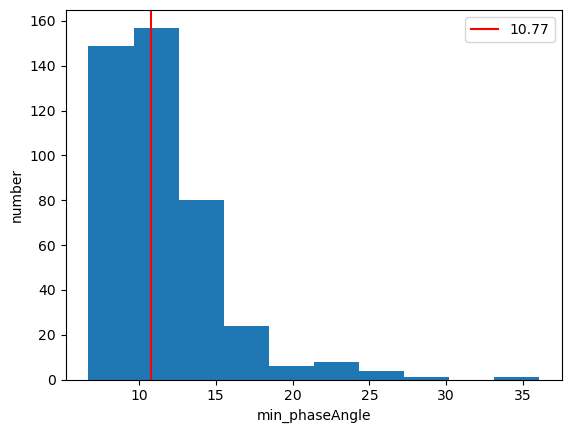

median(max_phaseAngle) = 11.800634384155273


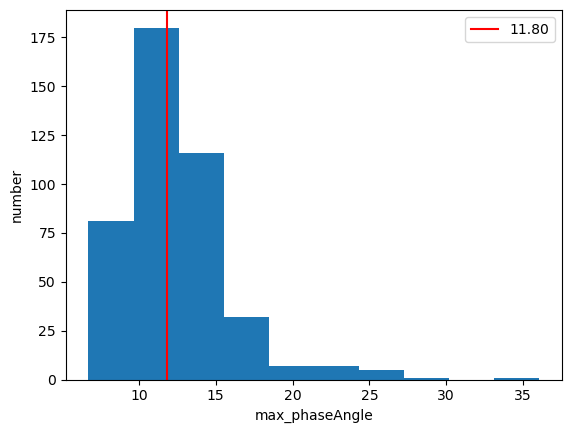

median(range_phaseAngle) = 0.4159836769104004


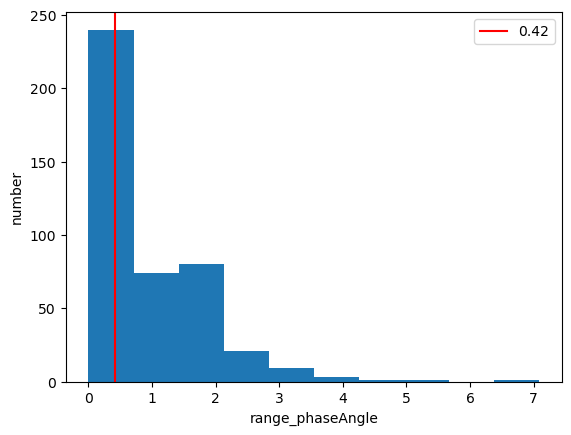

In [23]:
df_plot = df_mag

for x_plot in ["min_phaseAngle","max_phaseAngle","range_phaseAngle"]:
               
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    
    ax1.hist(df_plot[x_plot])

    med_x = np.median(df_plot[x_plot])
    print("median({}) = {}".format(x_plot,med_x))
    ax1.axvline(med_x, c= "r", label = "{:.2f}".format(med_x))
        
    ax1.legend()
    ax1.set_xlabel(x_plot)
    ax1.set_ylabel("number")
    
    plt.show()

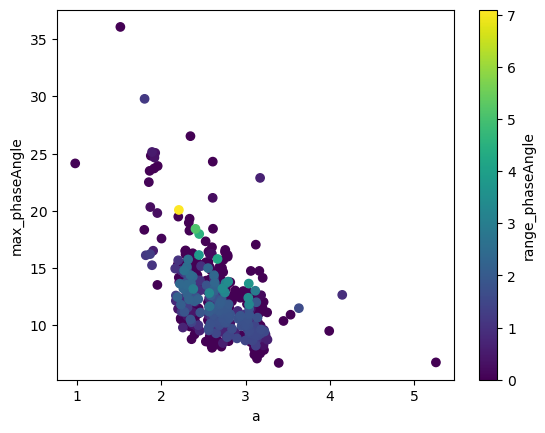

In [24]:
# plot the maximum observed phase angle for each object as a function of semimajor axis
x_plot = "a"
y_plot = "max_phaseAngle"
c_plot = "range_phaseAngle"
df_plot = df_mag.sort_values(c_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = plt.colorbar(s1)

# Maximum possible phase angle as a function of semimajor axis (for circular orbit)
# _x = np.linspace(np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot]))
# ax1.plot(_x, np.arcsin(1.0/_x), c = "r")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar1.set_label(c_plot)

plt.show()


In [25]:
# plot the object with the largest phase curve coverage
ssobjid = df_mag.iloc[np.argmax(df_mag["range_phaseAngle"])]["ssObjectId"]

2.116361166253064e+16 2001 SQ248
g 7
i 7
r 6
z 2


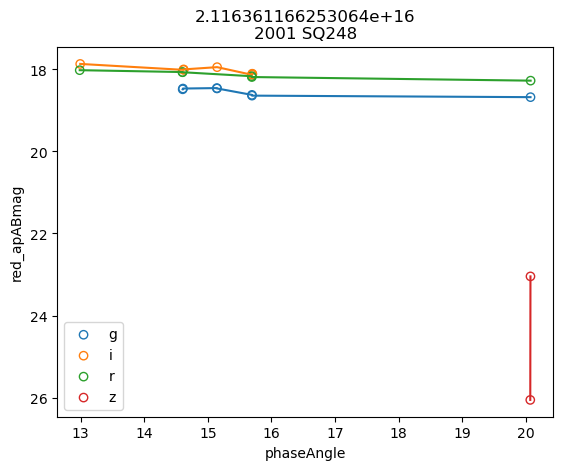

In [26]:
# Plot the phase curve
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


2.116361166253064e+16 2001 SQ248
g 7
i 7
r 6
z 2


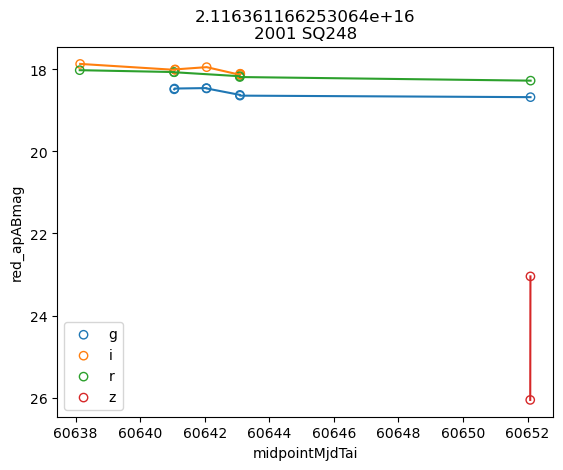

In [27]:
# Look at the lightcurve (note that this is very similar to the phase curve given the small observing baseline)
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "midpointMjdTai"
y_plot = "red_apABmag"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


# Unusual photometry?
ssObjectId = 21163611662530641 appears to have extremely faint detections in the z band. This seems fishy, let's look at the observations:

In [28]:
# # Inspect all observations in full
# df = df_obs[df_obs["ssObjectId"] == ssobjid]
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# #     display(df)
# df

The faint detections have a number of nan values, which appear to be caused by an attempted dipole fit (`dipoleFitAttempted == True`)
See also ssObjectId for another example 21163611677341266.

Furthermore some objects (e.g. ssObjectId = 23133931615302707) still have faint measurements, and these have nan values for trailing measurements (`shape_flag == True`).
NB not all observations with `shape_flag == True` appear to be outlying.

In [29]:
# dipoleFitAttempted==True example objects
# ssobjid = 21163611662530641
# ssobjid = 21163611677341266

# shape_flag==True example object
ssobjid = 23133931615302707

In [30]:
# # Inspect all observations in full
# df = df_obs[df_obs["ssObjectId"] == ssobjid]
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# #     display(df)
# df

23133931615302707 2024 WX104
g 6
i 7
r 6


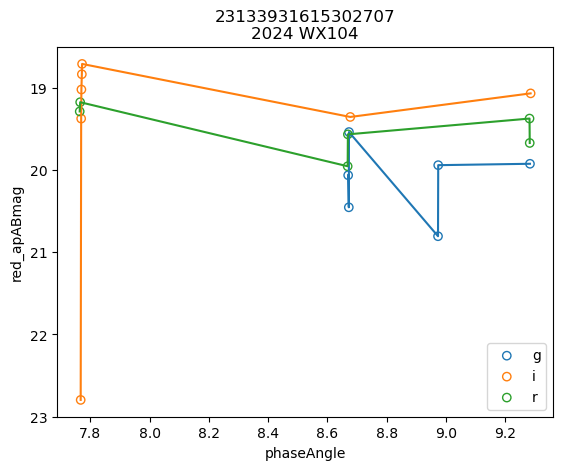

In [31]:
# Plot the phase curve
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


In [32]:
df_obs[~(df_obs["dipoleFitAttempted"])].dropna(subset = ["red_apABmag"])

,apFlux,apFluxErr,apFlux_flag,apFlux_flag_apertureTruncated,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,x,xErr,y,yErr,apABmag,psfABmag,trailABmag,red_apABmag,red_psfABmag,red_trailABmag
2,4369.830078,353.485992,False,False,g,30,False,6.293278,37.819684,6.293278,...,22.427637,0.209728,1919.808569,0.221328,22.298840,22.315632,22.283075,18.822573,18.839365,18.806808
3,4400.299805,343.942993,False,False,g,30,False,6.293452,37.820504,6.293452,...,1134.479535,0.144288,3253.946654,0.205547,22.291296,22.377724,22.347549,18.815075,18.901505,18.871330
4,4484.660156,348.970001,False,False,g,27,False,6.293351,37.820085,6.293351,...,690.930377,0.128695,3934.376414,0.170207,22.270678,22.363127,22.367790,18.794434,18.886883,18.891546
5,9565.330078,718.203979,False,False,i,23,False,6.293173,37.819193,6.293173,...,1153.779497,0.094149,3267.275036,0.161130,21.448250,21.450617,21.455692,17.971954,17.974321,17.979397
6,9743.110352,683.086975,False,False,i,28,False,6.293077,37.818787,6.293077,...,710.218686,0.106217,3946.933040,0.154775,21.428257,21.485264,21.439354,17.951939,18.008945,17.963036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5983,7770.459961,762.304993,False,False,i,22,False,7.377816,37.396720,7.377816,...,3016.409938,0.162306,94.529010,0.148195,21.673882,21.790102,21.857672,18.209126,18.325346,18.392916
5984,6107.979980,776.213013,False,False,i,20,False,7.377729,37.396368,7.377729,...,2576.376926,0.156659,771.566736,0.104696,21.935255,21.792442,21.799683,18.470480,18.327667,18.334908
5985,2579.620117,767.234009,False,False,i,15,False,7.363029,37.459273,7.363029,...,3728.398520,0.614278,743.073951,0.245688,22.871111,23.155102,23.111879,21.192036,21.476027,21.432804
5986,1180.810059,768.083984,False,False,i,15,False,7.391163,37.428004,7.391163,...,3060.728972,0.456301,395.037003,0.477649,23.719551,23.114958,23.076500,21.584606,20.980013,20.941555


# Group by ssObjectId and band
These summary stats allow us to assess changes in brightness in each band for each object.
Significant changes in a single band could indicate a rotational amplitude (or weird measurements).
Changes between mean brightness in different bands for a given object indicate colours.

In [33]:
# We want to exclude unusual photometry from our summary statistics so we define a mask
all_obs_mask = ~((df_obs["dipoleFitAttempted"]) | (df_obs["shape_flag"]))

# drop anything with a flag for dipole or shape
df_obs[~all_obs_mask][["shape_flag","dipoleFitAttempted"]]

,shape_flag,dipoleFitAttempted
0,False,True
1,False,True
10,True,True
21,True,True
23,False,True
...,...,...
5935,True,False
5941,True,False
5952,False,True
5953,False,True


In [34]:
# generate the summary statistics, by object and band, and excluding possible weird photometry
gb_obs_band = df_obs[all_obs_mask].dropna(subset = ["red_apABmag","red_psfABmag","red_trailABmag"]).groupby(["ssObjectId","band"])

df_ptp_band = gb_obs_band[['red_apABmag',"red_psfABmag","red_trailABmag","phaseAngle"]].agg(np.ptp).reset_index()
df_ptp_band = df_ptp_band.rename({'red_apABmag':"range_red_apABmag",
                                  'red_psfABmag':"range_red_psfABmag",
                                  'red_trailABmag':"range_red_trailABmag",
                        "phaseAngle":"range_phaseAngle"}, axis = 1)

df_min_band = gb_obs_band[["red_apABmag","red_psfABmag","red_trailABmag","phaseAngle"]].min().reset_index()
df_min_band = df_min_band.rename({'red_apABmag':"min_red_apABmag",
                                  'red_psfABmag':"min_red_psfABmag",
                                  'red_trailABmag':"min_red_trailABmag",
                        "phaseAngle":"min_phaseAngle"}, axis = 1)

df_max_band = gb_obs_band[["red_apABmag","red_psfABmag","red_trailABmag","phaseAngle"]].min().reset_index()
df_max_band = df_max_band.rename({'red_apABmag':"max_red_apABmag",
                                  'red_psfABmag':"max_red_psfABmag",
                                  'red_trailABmag':"max_red_trailABmag",
                        "phaseAngle":"max_phaseAngle"}, axis = 1)

df_mean_band = gb_obs_band[["red_apABmag","red_psfABmag","red_trailABmag","phaseAngle"]].mean().reset_index()
df_mean_band = df_mean_band.rename({'red_apABmag':"mean_red_apABmag",
                                    'red_psfABmag':"mean_red_psfABmag",
                                    'red_trailABmag':"mean_red_trailABmag",
                        "phaseAngle":"mean_phaseAngle"}, axis = 1)

df_mag_band = df_ptp_band.copy()
df_mag_band = df_mag_band.merge(df_min_band, on = ["ssObjectId","band"])
df_mag_band = df_mag_band.merge(df_max_band, on = ["ssObjectId","band"])
df_mag_band = df_mag_band.merge(df_mean_band, on = ["ssObjectId","band"])
# df_mag_band = df_mag_band.merge(df_obj, on = "ssObjectId")

# Inspect the object with the most observations

In [35]:
# df_obj.iloc[np.argmax(df_obj["numObs"])]

In [36]:
ssobjid = df_obj.iloc[np.argmax(df_obj["numObs"])]["ssObjectId"] # ssObjectId with the most observations

In [37]:
# df = df_obs[(all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)]
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     display(df)
# df

In [38]:
# df_obs[(~all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)]

g 34
i 14
r 28
z 53


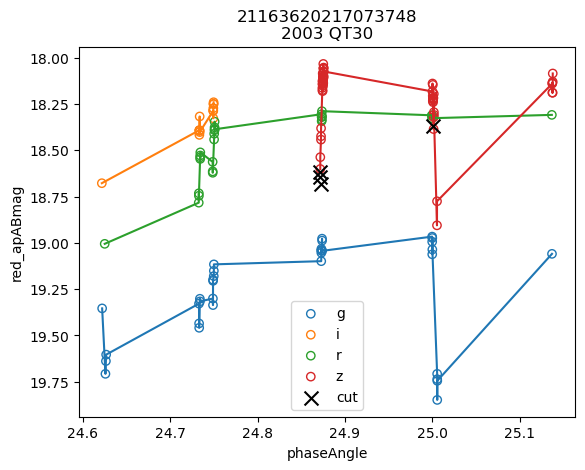

In [39]:
# plot the phase curve and indicate observations that we have excluded
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[all_obs_mask & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)
df_plot2 = df_obs[(~all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

            
mlist = ["o","s","*"]
slist = [50,75,100]
for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                # marker = mlist[i],
                # s = slist[i],
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.scatter(df_plot2[x_plot],df_plot2[y_plot],
            s = 100,
            marker = "x", c = "k", label = "cut", zorder = 5)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))
plt.savefig("{}_{}".format(ssobjid,"_".join(mpc_des.split(" "))))

plt.show()


# What is the relation between the different flux/mag measurements?
DiaSource gives a number of flux measurements, in particular:
- aperture
- psf
- trailed

21163620217073748 2003 QT30


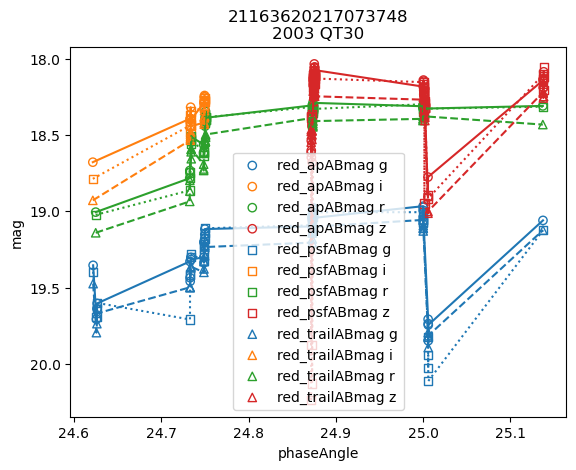

In [40]:
# Plot the phase curve in multiple flux methods for a given object
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
print(ssobjid,mpc_des)

x_plot = "phaseAngle"
df_plot = df_obs[df_obs["ssObjectId"] == ssobjid].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

for y_plot,m,ls in zip(["red_apABmag","red_psfABmag","red_trailABmag"],["o","s","^"],["-",":","--"]):
    for i,filt in enumerate(np.unique(df_plot["band"])):
        _df_plot = df_plot[df_plot["band"]==filt]
        ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                    edgecolor = "C{}".format(i),
                    facecolor = "none",
                    marker = m,
                    label = "{} {}".format(y_plot,filt))
        ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
                 ls = ls,
                 c = "C{}".format(i),)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel("mag")
ax1.invert_yaxis()

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()


g 1916


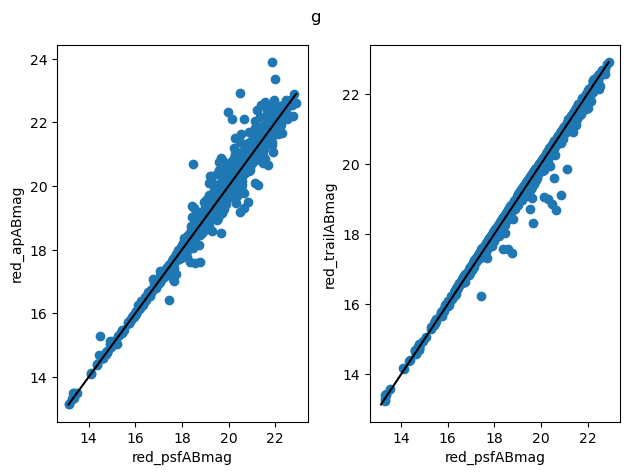

i 2088


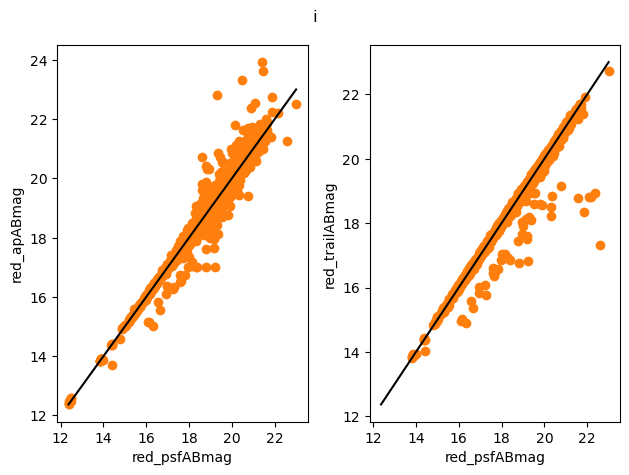

r 1536


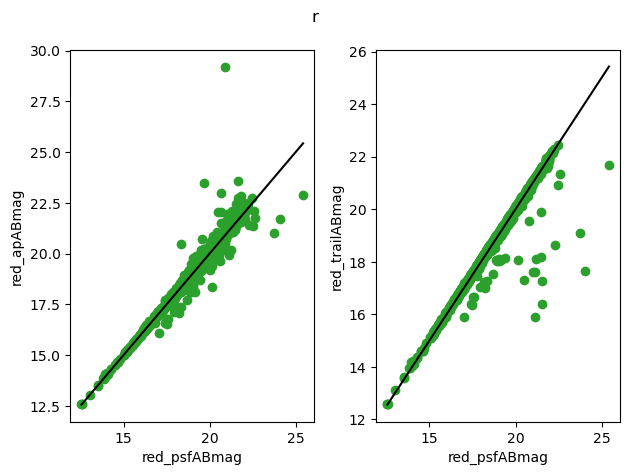

u 15


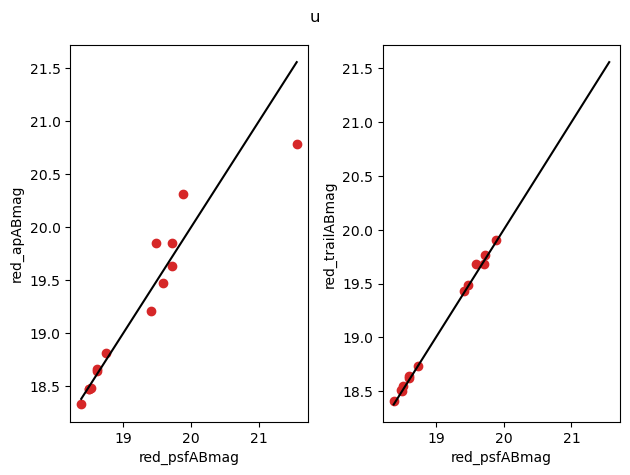

z 433


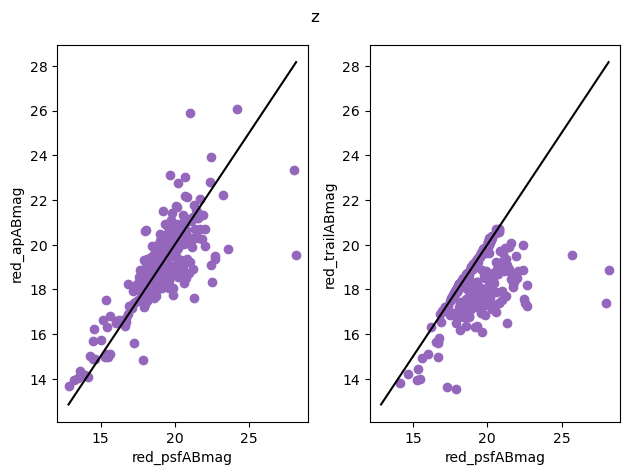

In [41]:
# check the relation between different flux methods
x_plot = "red_psfABmag"
y_plot = "red_apABmag"
y_plot2 = "red_trailABmag"
df_plot = df_obs

for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))

    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                c = "C{}".format(i),)

    ax1.plot([np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
              [np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
                                               c = "k")

    ax2.scatter(_df_plot[x_plot],_df_plot[y_plot2],
                c = "C{}".format(i),)

    ax2.plot([np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
              [np.amin(_df_plot[x_plot]),np.amax(_df_plot[x_plot])],
                                               c = "k")

    fig.suptitle(filt)
    ax1.set_xlabel(x_plot)
    ax1.set_ylabel(y_plot)
    ax2.set_xlabel(x_plot)
    ax2.set_ylabel(y_plot2)

    plt.tight_layout()
    plt.show()


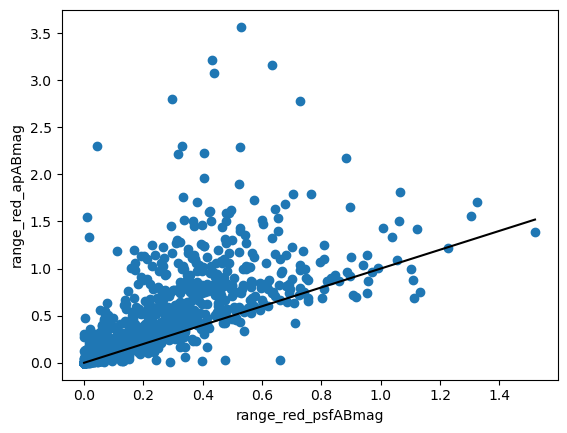

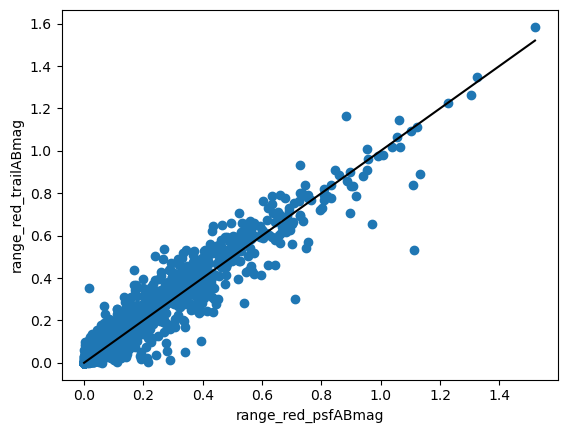

In [42]:
# What method should we use to assess changes in brightness of an object?
# assess the relation between the range statistics of the reduced magnitudes
x_plot = "range_red_psfABmag"
df_plot = df_mag_band

for y_plot in ["range_red_apABmag","range_red_trailABmag"]:
               
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = plt.subplot(gs[0,0])
    
    ax1.scatter(df_plot[x_plot],df_plot[y_plot])
        

    ax1.plot([np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])],
              [np.amin(df_plot[x_plot]),np.amax(df_plot[x_plot])],
                                               c = "k")
    
    ax1.set_xlabel(x_plot)
    ax1.set_ylabel(y_plot)
    
    plt.show()

Aperture magnitudes appear to overestimate the range statistic, use psf or trailed instead

In [43]:
df_mag_band.sort_values("range_red_psfABmag")

,ssObjectId,band,range_red_apABmag,range_red_psfABmag,range_red_trailABmag,range_phaseAngle,min_red_apABmag,min_red_psfABmag,min_red_trailABmag,min_phaseAngle,max_red_apABmag,max_red_psfABmag,max_red_trailABmag,max_phaseAngle,mean_red_apABmag,mean_red_psfABmag,mean_red_trailABmag,mean_phaseAngle
0,20890932542191434,r,0.000000,0.000000,0.000000,0.000000,16.914629,16.891289,16.963734,13.537582,16.914629,16.891289,16.963734,13.537582,16.914629,16.891289,16.963734,13.537582
3,20890950007009348,g,0.000000,0.000000,0.000000,0.000000,13.515736,13.515648,13.569553,12.401078,13.515736,13.515648,13.569553,12.401078,13.515736,13.515648,13.569553,12.401078
1106,23133931615303734,i,0.000000,0.000000,0.000000,0.000000,21.106291,21.105425,21.086863,13.051321,21.106291,21.105425,21.086863,13.051321,21.106291,21.105425,21.086863,13.051321
4,20890950007009348,r,0.000000,0.000000,0.000000,0.000000,13.021914,13.024063,13.123085,12.402100,13.021914,13.024063,13.123085,12.402100,13.021914,13.024063,13.123085,12.402100
74,21163611526346049,i,0.000000,0.000000,0.000000,0.000000,17.483479,17.471437,17.547926,8.789922,17.483479,17.471437,17.547926,8.789922,17.483479,17.471437,17.547926,8.789922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,21164724124727367,i,0.753725,1.133451,0.890890,0.981040,20.156754,20.119890,20.175570,13.805681,20.156754,20.119890,20.175570,13.805681,20.373936,20.469776,20.449219,14.389399
445,21164710955528273,i,1.217495,1.226242,1.227415,1.496894,18.070066,18.093655,18.075657,9.240316,18.070066,18.093655,18.075657,9.240316,18.473112,18.498974,18.453951,10.312421
1025,23133931615302969,i,1.556950,1.303993,1.263535,0.926290,19.448683,19.628761,19.602154,11.735900,19.448683,19.628761,19.602154,11.735900,20.350758,20.367460,20.318186,12.195651
1024,23133931615302969,g,1.709867,1.323189,1.349358,0.933676,20.176586,20.214581,20.145849,11.726223,20.176586,20.214581,20.145849,11.726223,21.084309,21.002569,20.922474,12.145342


In [44]:
ssobjid = df_mag_band.iloc[np.argmax(df_mag_band["range_red_psfABmag"])]["ssObjectId"]

g 4
i 7
r 4


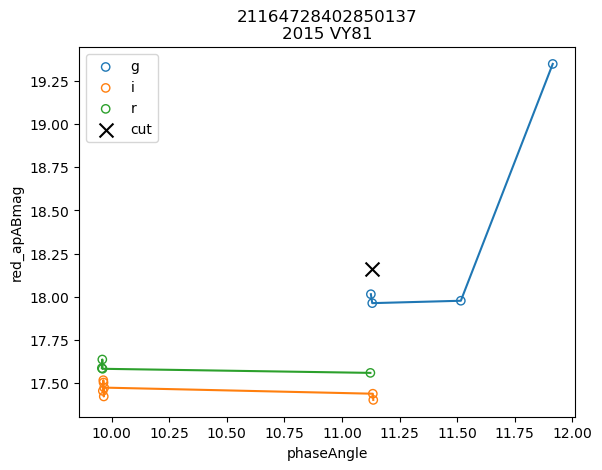

In [45]:
# plot the phase curve and indicate observations that we have excluded
mpc_des = df_obj[df_obj["ssObjectId"]==ssobjid].iloc[0]["mpcDesignation"]
x_plot = "phaseAngle"
y_plot = "red_apABmag"
df_plot = df_obs[all_obs_mask & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)
df_plot2 = df_obs[(~all_obs_mask) & (df_obs["ssObjectId"] == ssobjid)].sort_values(x_plot)

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

            
mlist = ["o","s","*"]
slist = [50,75,100]
for i,filt in enumerate(np.unique(df_plot["band"])):
    _df_plot = df_plot[df_plot["band"]==filt]
    print(filt,len(_df_plot))
    ax1.scatter(_df_plot[x_plot],_df_plot[y_plot],
                edgecolor = "C{}".format(i),
                facecolor = "none",
                # marker = mlist[i],
                # s = slist[i],
                label = filt)
    ax1.plot(_df_plot[x_plot],_df_plot[y_plot],
             c = "C{}".format(i),)

ax1.scatter(df_plot2[x_plot],df_plot2[y_plot],
            s = 100,
            marker = "x", c = "k", label = "cut", zorder = 5)

ax1.legend()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.title("{}\n{}".format(ssobjid,mpc_des))

plt.show()
